# Code and additional analysis for Case Study 1

## Install Pyro for probabilistic programming

In [2]:
!pip install pyro-ppl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [7]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests

import numpy as np
from tqdm.notebook import tqdm

import torch
import pyro
import pyro.distributions as dist
from pyro.nn import PyroSample, PyroModule

import tqdm.notebook as tqdm
from tqdm.notebook import trange

import arviz as az

import math

plt.style.use("bmh")

## Load and visualize the data

In [4]:
data_path = "https://raw.githubusercontent.com/johanneskopton/value-of-precision/refs/heads/main/case_study2/data/"

In [5]:
tdf = pd.read_csv(f"{data_path}/thinning_data.csv")
prices = pd.read_csv(f"{data_path}/prices.csv", sep=";", index_col="size")
tdf["clusters"] = tdf["low"] + tdf["high"]

In [8]:
with requests.get(f"{data_path}/harvesting_data_number.h5") as r:
    with open(f"harvesting_data_number.h5", "wb") as f:
        f.write(r.content)
with requests.get(f"{data_path}/harvesting_data_mass.h5") as r:
    with open(f"harvesting_data_mass.h5", "wb") as f:
        f.write(r.content)
hdf = pd.read_hdf("harvesting_data_number.h5")
hdf_mass = pd.read_hdf("harvesting_data_mass.h5")

In [9]:
tdf = tdf.loc[tdf.tree_no.isin(hdf.index)]

In [10]:
tdf.index = tdf.tree_no
tdf.drop(columns=["tree_no"], inplace=True)

Check if tree number match

In [14]:
list(tdf.index) == list(hdf.index)

True

Remove chemical treatment, as it is not analyzed here


In [13]:
non_chem_idxs = (tdf.target != "chem")
tdf = tdf.loc[non_chem_idxs]
hdf = hdf.loc[non_chem_idxs]
hdf_mass = hdf_mass.loc[non_chem_idxs]

After manual thinning, clower clusters are reduced to target number
(if it was higher than the target number in the first place).

In [15]:
def get_clusters_after(df):
    df["clusters_after"] = np.nan
    df.loc[df.target == "75", "clusters_after"] = np.minimum(
        df.clusters.loc[df.target == "75"], 75)
    df.loc[df.target == "100", "clusters_after"] = np.minimum(
        df.clusters.loc[df.target == "100"], 100)
    df.loc[df.target == "125", "clusters_after"] = np.minimum(
        df.clusters.loc[df.target == "125"], 125)
    return df

In [16]:
tdf = get_clusters_after(tdf)

Text(0.5, 1.0, 'after thinning')

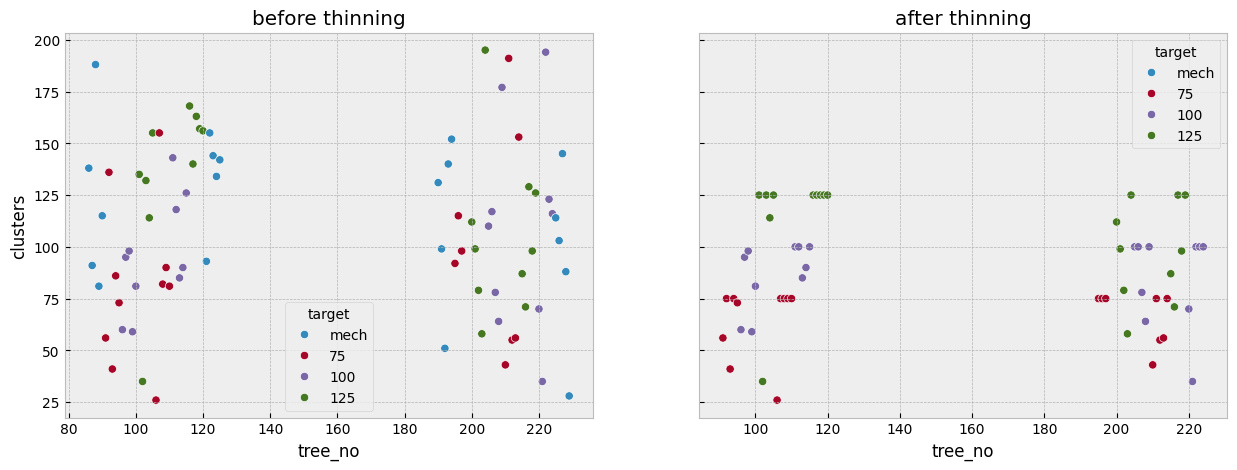

In [17]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
sns.scatterplot(tdf, x="tree_no", y="clusters", hue="target", ax=axs[0])
sns.scatterplot(tdf, x="tree_no", y="clusters_after", hue="target", ax=axs[1])
axs[0].set_title("before thinning")
axs[1].set_title("after thinning")

### Visualize harvesting data

In [18]:
hdf_mass.sum(axis=0).unstack(level=1)

,0,15,25,50,75
0,3.063,2.564,6.166,3.345,0.837
60,6.418,6.814,16.513,15.037,4.165
65,9.439,11.861,47.165,40.349,11.801
70,14.827,15.380,67.552,72.489,25.725
75,10.365,10.251,54.609,63.008,26.434
80,4.146,4.267,21.381,31.787,16.191
85,0.599,0.640,5.093,8.966,4.631
90,0.000,0.000,0.988,1.619,1.359
95,0.000,0.000,0.000,0.000,0.000
100,0.000,0.000,0.000,0.000,0.000


Heatmaps of number of apples per quality class.
X axis is coloration in %. Y axis is size in mm.

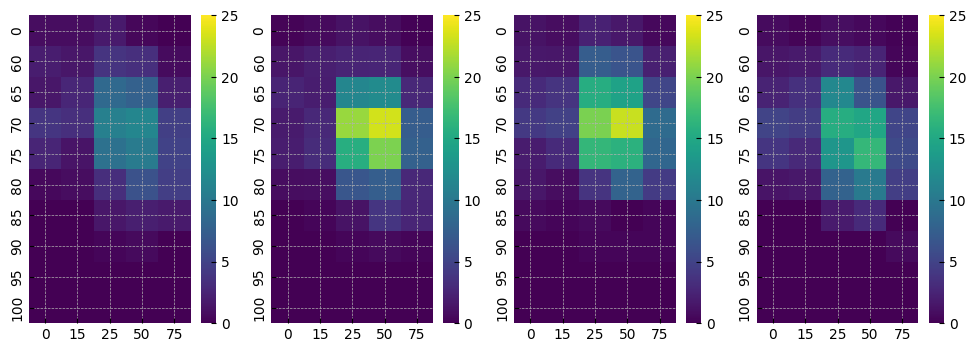

In [20]:
fig, axs = plt.subplots(1, 4, figsize=(12, 4))
sns.heatmap(hdf_mass.loc[tdf.target=="75"].sum(axis=0).unstack(level=1), ax=axs[0], cmap="viridis", vmax=25)
sns.heatmap(hdf_mass.loc[tdf.target=="100"].sum(axis=0).unstack(level=1), ax=axs[1], cmap="viridis", vmax=25)
sns.heatmap(hdf_mass.loc[tdf.target=="125"].sum(axis=0).unstack(level=1), ax=axs[2], cmap="viridis", vmax=25)
sns.heatmap(hdf_mass.loc[tdf.target=="mech"].sum(axis=0).unstack(level=1), ax=axs[3], cmap="viridis", vmax=25)
pass

Total mass per quality class.

In [21]:
print(hdf_mass.loc[tdf.target=="75"].sum().unstack(level=1).sum().sum())
print(hdf_mass.loc[tdf.target=="100"].sum().unstack(level=1).sum().sum())
print(hdf_mass.loc[tdf.target=="125"].sum().unstack(level=1).sum().sum())

121.88700000000001
176.014
194.696


In [22]:
hdf_sizes = hdf.groupby(level=0, axis=1).sum()
hdf_sizes_mass = hdf_mass.groupby(level=0, axis=1).sum()

In [23]:
average_sizes = np.array([55] + list((hdf_sizes.columns[1:] + (hdf_sizes.columns[1:]+5)) / 2))

In [24]:
hdf_colors = hdf.groupby(level=1, axis=1).sum()

In [25]:
tdf

,row,low,high,target,experimentor,clusters,clusters_after
tree_no,,,,,,,
86,2,101,37,mech,JK,138,NaN
87,2,67,24,mech,JK,91,NaN
88,2,69,119,mech,JK,188,NaN
89,2,50,31,mech,JK,81,NaN
90,2,64,51,mech,JK,115,NaN
...,...,...,...,...,...,...,...
225,3,84,30,mech,JK,114,NaN
226,3,60,43,mech,JK,103,NaN
227,3,92,53,mech,JK,145,NaN


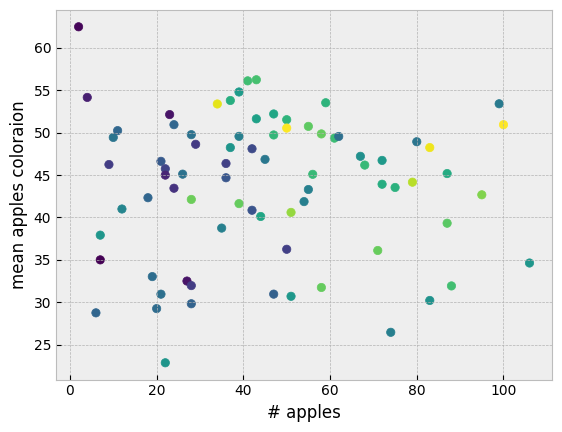

In [26]:
mean_color = np.sum(hdf_colors.iloc[:, :-1] * (hdf_colors.columns[:-1] +
                   hdf_colors.columns[1:]) / 2, axis=1) / np.sum(hdf_colors.iloc[:, :-1], axis=1)
fig, ax = plt.subplots()
ax.scatter(hdf.sum(axis=1), mean_color, c=tdf.clusters, cmap="viridis")
ax.set_xlabel("# apples")
ax.set_ylabel("mean apples coloraion")
pass

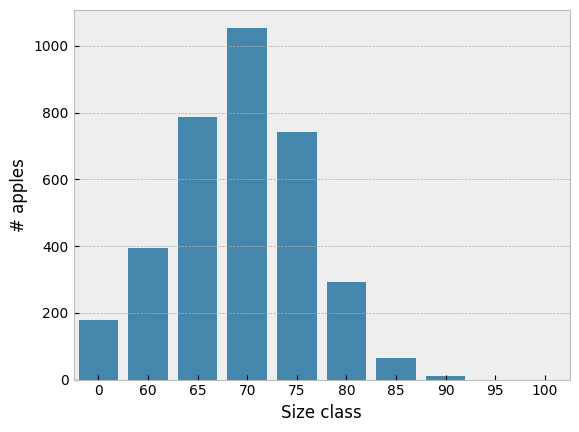

In [29]:
sns.barplot(hdf_sizes.sum(axis=0))
plt.xlabel("Size class")
plt.ylabel("# apples")
pass

In [30]:
color_bins = (list(hdf_colors.columns) + [100])
color_bin_means = (np.array(color_bins[1:]) + np.array(color_bins[:-1])) / 2

In [31]:
class2_bins = 3
mean_coloration = (hdf_colors*color_bin_means).sum(axis=1) / hdf_colors.sum(axis=1)
class2_coloration = hdf_colors.iloc[:, :class2_bins].sum(axis=1) / hdf_colors.sum(axis=1)
class1_coloration = hdf_colors.iloc[:, class2_bins:].sum(axis=1) / hdf_colors.sum(axis=1)

Combine thinning data with harvesting data.

In [32]:
joint_df = pd.merge(tdf, pd.DataFrame({
    "apples": hdf_sizes.sum(axis=1),
    "mass": hdf_sizes_mass.sum(axis=1),
    "mean_coloration": mean_coloration,
    "class1_coloration": class1_coloration,
    "class2_coloration": class2_coloration,
    }), left_on="tree_no", right_index=True)
joint_df["average_mass"] = joint_df.mass / joint_df.apples

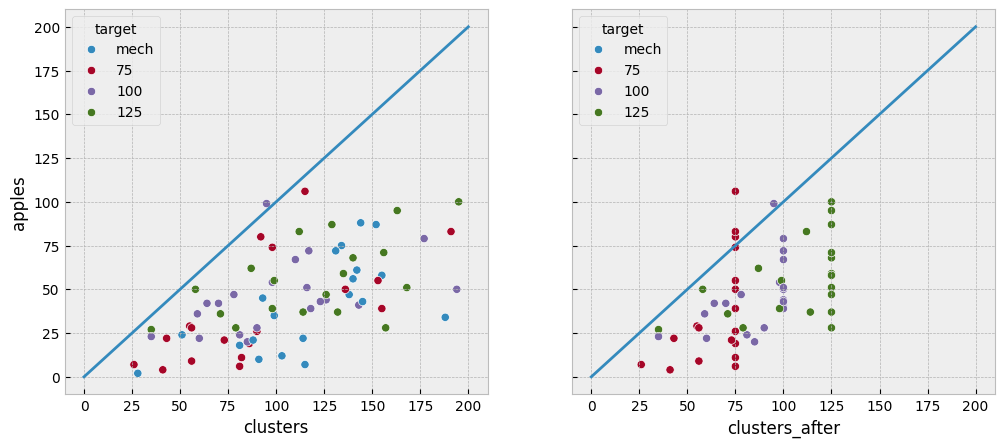

In [33]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12,5))
sns.scatterplot(joint_df, x="clusters", y="apples", ax=axs[0], hue="target")
sns.scatterplot(joint_df, x="clusters_after", y="apples", ax=axs[1], hue="target")
axs[0].plot([0, 200], [0, 200])
axs[1].plot([0, 200], [0, 200])

<Axes: xlabel='target', ylabel='class1_coloration'>

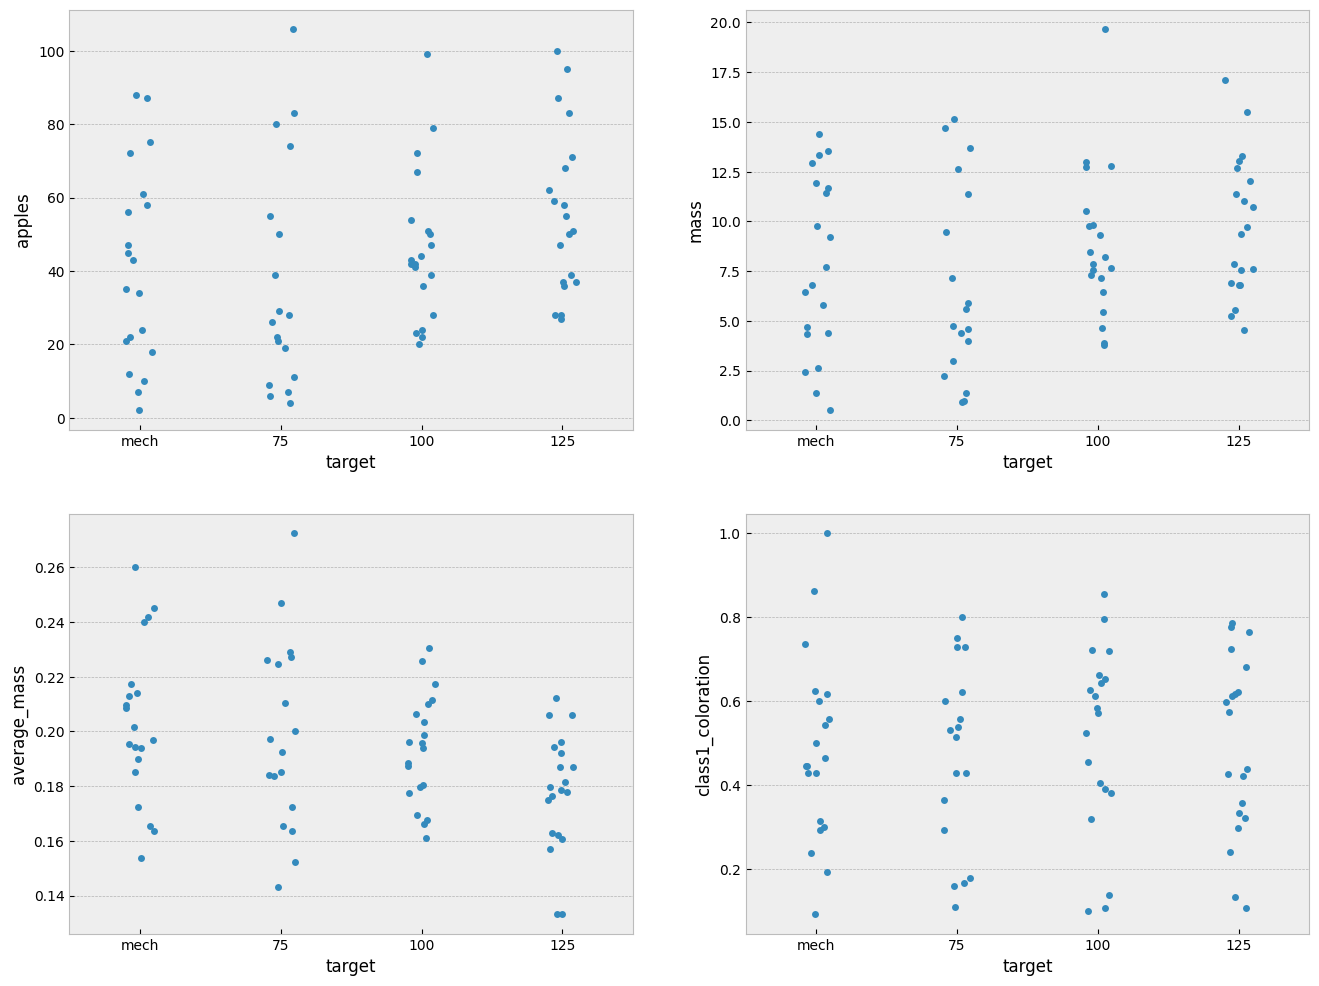

In [34]:
fig, axs = plt.subplots(2, 2, figsize=(16,12))
sns.stripplot(joint_df, x="target", y="apples", ax=axs[0][0])
sns.stripplot(joint_df, x="target", y="mass", ax=axs[0][1])
sns.stripplot(joint_df, x="target", y="average_mass", ax=axs[1][0])
sns.stripplot(joint_df, x="target", y="class1_coloration", ax=axs[1][1])

## Size/Mass calculation

In [35]:
hdf.groupby(level=1, axis=1).sum()

,0,15,25,50,75
86,0.0,2.0,16.0,20.0,9.0
87,0.0,1.0,3.0,5.0,1.0
88,1.0,0.0,8.0,19.0,6.0
89,0.0,3.0,7.0,5.0,3.0
90,1.0,1.0,2.0,2.0,1.0
...,...,...,...,...,...
225,7.0,7.0,6.0,1.0,1.0
226,1.0,2.0,3.0,4.0,2.0
227,0.0,0.0,6.0,18.0,19.0
228,7.0,3.0,6.0,5.0,0.0


In [36]:
number_by_color = hdf.groupby(level=1, axis=1).sum()
number_by_color_long = pd.melt(number_by_color.reset_index(names="tree_no"), var_name="coloration", value_name="number", id_vars=["tree_no"])
mass_by_color = hdf_mass.groupby(level=1, axis=1).sum()
mass_by_color_long = pd.melt(mass_by_color.reset_index(names="tree_no"), var_name="coloration", value_name="mass", id_vars=["tree_no"])
all_by_color_long = pd.merge(number_by_color_long, mass_by_color_long, on=["tree_no", "coloration"])

In [37]:
average_sizes_by_tree = pd.DataFrame({"average_size": np.dot(
    hdf_sizes, average_sizes) / np.sum(hdf_sizes, axis=1), "tree_no": hdf_sizes.index})

In [38]:
all_by_color_long = pd.merge(all_by_color_long, average_sizes_by_tree, on="tree_no")
all_by_color_long["average_mass"] = all_by_color_long.mass / \
    all_by_color_long.number
all_by_color_long.dropna(inplace=True)

In [39]:
all_by_tree = all_by_color_long.groupby("tree_no").mean()

Regression for conversion from size to mass.

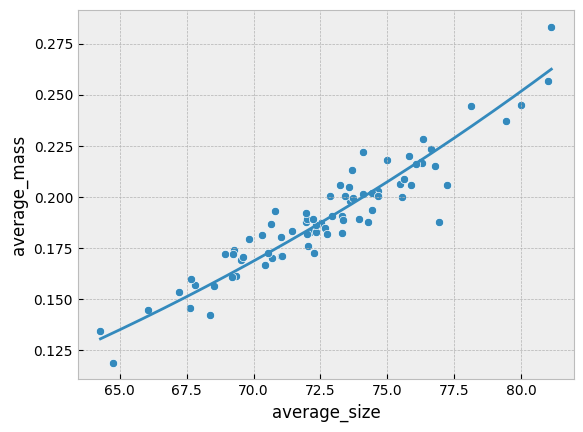

In [41]:
# multiply mass factor by apple_size**3 to obtain mass
mass_factor = np.linalg.lstsq(np.expand_dims(
    all_by_tree["average_size"]**3, axis=1), all_by_tree["average_mass"])[0][0]

def size_to_mass(size):
    return mass_factor * size ** 3

def mass_to_size(mass):
    return (mass / mass_factor) ** (1/3)

fig, ax = plt.subplots()
sns.scatterplot(all_by_tree, x="average_size", y="average_mass", ax=ax)
size_range = np.arange(all_by_tree.average_size.min(), all_by_tree.average_size.max(), 0.01)
ax.plot(size_range, size_to_mass(size_range))

Quality changes from 100 to 125 flowers

<Axes: >

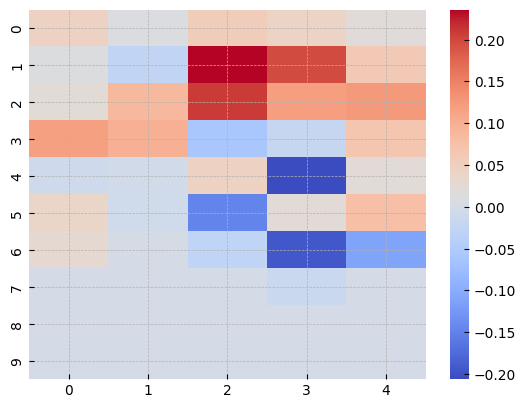

In [42]:
fig, ax = plt.subplots()
diff = hdf_mass.loc[tdf.target == "125"].mean(axis=0).unstack(level=1).to_numpy() - \
    hdf_mass.loc[tdf.target == "100"].mean(axis=0).unstack(level=1).to_numpy()
sns.heatmap(diff, cmap="coolwarm", ax=ax)

### Prepare prices and mass/size conversion

In [43]:
size_bins = list(hdf_mass.sum(axis=0).unstack(level=1).index) + [1000]

kg_per_apple = hdf_mass.sum(axis=0).unstack(
    level=1).to_numpy() / hdf.sum(axis=0).unstack(level=1).to_numpy()

kg_per_apple_theoretical = size_to_mass(
    np.resize(np.array(size_bins[1:-1] + [105]) - 2.5, (5, 10)).T)

kg_per_apple[np.isnan(kg_per_apple)] = kg_per_apple_theoretical[np.isnan(kg_per_apple)]

kg_per_apple = np.stack([kg_per_apple[:, :class2_bins].mean(
    axis=1), kg_per_apple[:, class2_bins:].mean(axis=1)], axis=1)

<ipython-input-43-4524e27db7fd>:3: RuntimeWarning: invalid value encountered in divide
  kg_per_apple = hdf_mass.sum(axis=0).unstack(


### Prepare quality categories

In [44]:
price_categories = torch.zeros((10, 2), dtype=torch.int16)

price_categories[3:, 0] = 1
price_categories[7:, 1] = 1
price_categories[2:4, 1] = 2
price_categories[4:7, 1] = 3


category_prices = torch.tensor([0.21, 0.50, 0.75, 0.92]) - torch.tensor([0.21, 0.33, 0.33, 0.33])

category_labels = ["cider", "class 2", "class 1 (small)", "class 1 (large)"]

price_categories, category_prices

(tensor([[0, 0],
         [0, 0],
         [0, 2],
         [1, 2],
         [1, 3],
         [1, 3],
         [1, 3],
         [1, 1],
         [1, 1],
         [1, 1]], dtype=torch.int16),
 tensor([0.0000, 0.1700, 0.4200, 0.5900]))

In [45]:
def get_revenue_torch(mass_array):
    return mass_array @ category_prices

In [46]:
fitting_tdf = tdf.loc[(~tdf.clusters_after.isna())]
fitting_targets = fitting_tdf.target.astype(int)
fitting_clusters = fitting_tdf.clusters.astype(int)

fitting_tdf_mech = tdf.loc[tdf.target=="mech"]
fitting_clusters_mech = fitting_tdf_mech.clusters.astype(int)

In [47]:
tdf.target.unique()

array(['mech', '75', '100', '125'], dtype=object)

In [48]:
fitting_tree_nos = fitting_targets.index.to_numpy()
fitting_tree_nos_mech = fitting_clusters_mech.index.to_numpy()
all_tree_nos = tdf.index.to_numpy()

X = torch.tensor(fitting_targets.to_numpy(), dtype=torch.int32)
X_before = torch.tensor(fitting_clusters.to_numpy(), dtype=torch.int32)
X_mech = torch.tensor(fitting_clusters_mech.to_numpy(), dtype=torch.int32)

In [49]:
y_all = np.empty((len(tdf), 10, 5), dtype=np.int32)
for i, tree_no in enumerate(all_tree_nos):
    y_all[i] = hdf.loc[tree_no].unstack(1).to_numpy()#.sum(axis=1)
y_all = torch.tensor(y_all, dtype=torch.int32)

In [50]:
# [class2, class1]
y_all2 = torch.stack([y_all[:, :, :class2_bins].sum(
    axis=2), y_all[:, :, class2_bins:].sum(axis=2)], dim=2)

In [51]:
y_all2_mass = y_all2 * kg_per_apple

In [52]:
y = torch.zeros((len(y_all2), 4), dtype=torch.int)
y_mass = torch.zeros((len(y_all2), 4), dtype=torch.float)

for i in range(4):
    y[:, i] = y_all2[:, price_categories==i].sum(axis=1)
    y_mass[:, i] = y_all2_mass[:, price_categories==i].sum(axis=1)

In [53]:
kg_per_apple_category = y_mass.mean(axis=0) / y.type(torch.float).mean(axis=0)

In [54]:
tdf_numbered = tdf.reset_index()

In [55]:
mech_idxs = tdf_numbered.loc[tdf_numbered["target"]=="mech"].index
target_idxs = tdf_numbered.loc[tdf_numbered["target"]!="mech"].index

In [56]:
y_mech = y[mech_idxs]
y_mass_mech = y_mass[mech_idxs]
y = y[target_idxs]
y_mass = y_mass[target_idxs]

In [57]:
print(get_revenue_torch(y_mass_mech).mean())
print(get_revenue_torch(y_mass)[torch.tensor((tdf[tdf.target!="mech"].target == "75").to_numpy())].mean())
print(get_revenue_torch(y_mass)[torch.tensor((tdf[tdf.target!="mech"].target == "100").to_numpy())].mean())
print(get_revenue_torch(y_mass)[torch.tensor((tdf[tdf.target!="mech"].target == "125").to_numpy())].mean())

tensor(2.2951)
tensor(1.9365)
tensor(2.7373)
tensor(2.6953)


In [58]:
xy_df = pd.DataFrame(data={
    "X": X,
    "y0": y[:, 0],
    "y1": y[:, 1],
    "y2": y[:, 2],
    "y3": y[:, 3],
})

xy_df_mass = pd.DataFrame(data={
    "X": X,
    "y0": y_mass[:, 0],
    "y1": y_mass[:, 1],
    "y2": y_mass[:, 2],
    "y3": y_mass[:, 3],
})

In [59]:
xy_df["total"] = xy_df.iloc[:, 1:].sum(axis=1)
xy_df_mass["total"] = xy_df_mass.iloc[:, 1:].sum(axis=1)

In [60]:
#xy_df.iloc[:, 1:] = xy_df.iloc[:, 1:].to_numpy() / xy_df.iloc[:, 1:].sum(axis=1).to_numpy().reshape(-1, 1)

In [61]:
# Convert the DataFrame to long format
xy_long_df = pd.melt(xy_df, id_vars=["X"], value_vars=["y0", "y1", "y2", "y3"],
                     var_name="category", value_name="y")

xy_long_df_mass = pd.melt(xy_df_mass, id_vars=["X"], value_vars=["y0", "y1", "y2", "y3"],
                     var_name="category", value_name="y")

Apple numbers/mass per quality class and thinning target.

Text(0.5, 1.0, 'numbers')

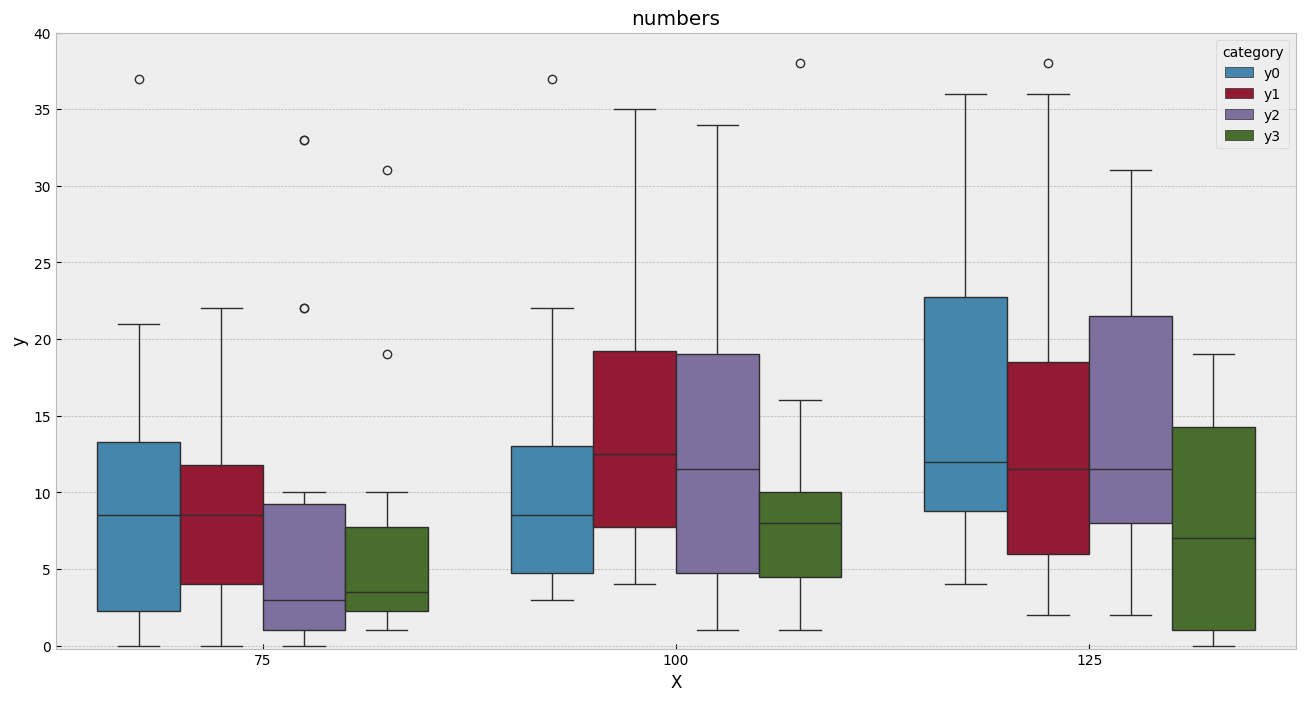

In [63]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(xy_long_df, x="X", y="y", hue="category", ax=ax)
ax.set_ylim(-.2, 40)
ax.set_title("numbers")

Text(0.5, 1.0, 'mass')

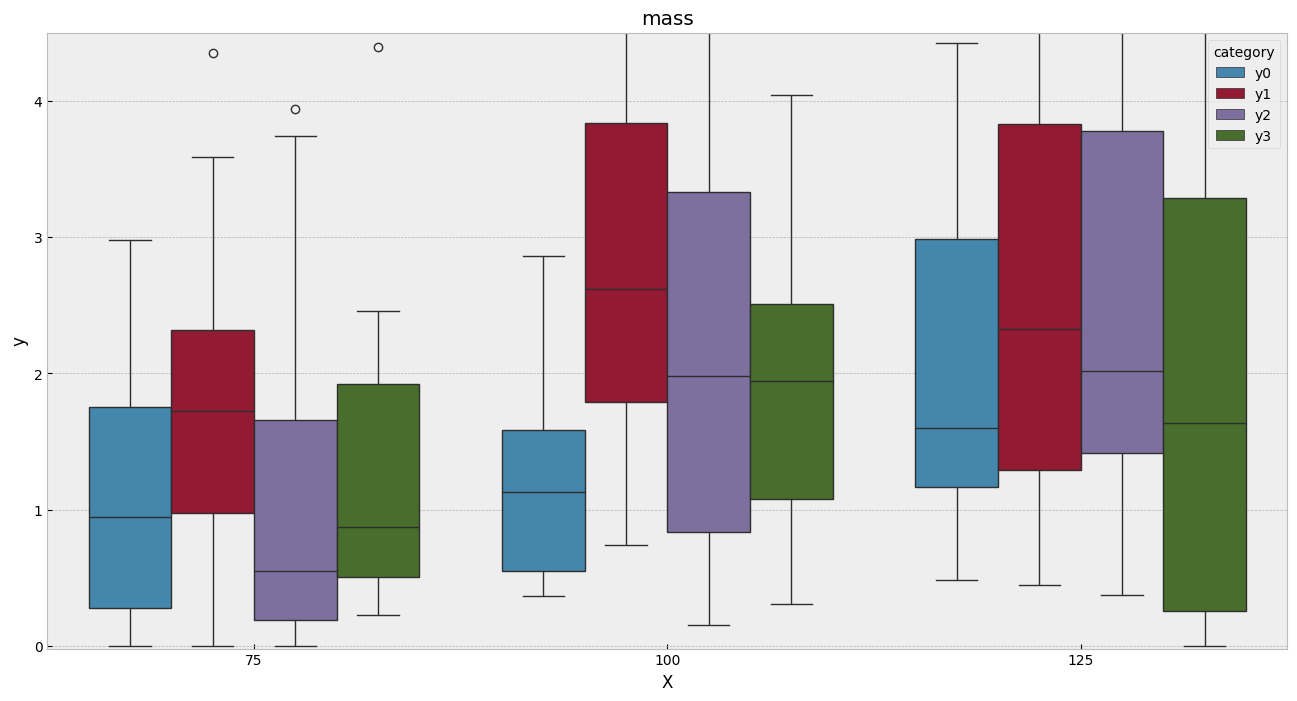

In [64]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(xy_long_df_mass, x="X", y="y", hue="category", ax=ax)
ax.set_ylim(-.02, 4.5)
ax.set_title("mass")

Apple revenue per thinning target.

Text(0.5, 1.0, 'revenue per tree')

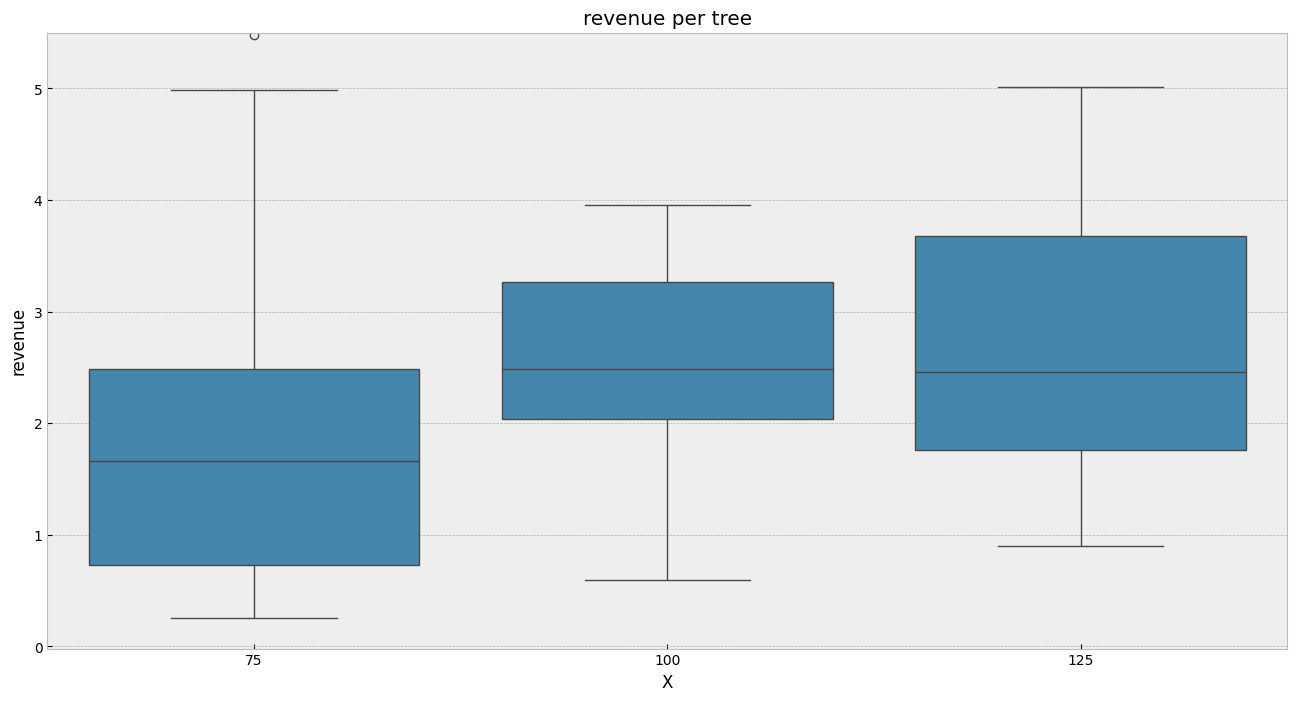

In [65]:
xy_df["revenue"] = get_revenue_torch(y_mass)

fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(xy_df, x="X", y="revenue", ax=ax)
ax.set_ylim(-.02, 5.5)
ax.set_title("revenue per tree")

## Fitting the thinning model

Define the model (as described in the paper)

In [68]:
n_classes = y.shape[1]
class AppleDistributionModelFitting(PyroModule):
    def __init__(
            self,
            apples_flower_param=None,
            apples_flower_param2=None,
            max_apples=None,
            beta0=None,
            beta1=None,
            beta2=None,
            overdispersion=None,
            thinned=True,
        ):
        super().__init__()
        if thinned:
            self.apples_flower_param = PyroSample(dist.LogNormal(0, 0.5))
            self.apples_flower_param2 = PyroSample(dist.LogNormal(3.5, 0.5))
            self.max_apples = PyroSample(dist.LogNormal(4.0, 0.5))
            self.overdispersion = PyroSample(dist.LogNormal(3, 1))

            self.beta0 = PyroSample(dist.Normal(0, 20).expand([4]).to_event(1))
            self.beta1 = PyroSample(dist.Normal(0, 10).expand([4]).to_event(1))
            self.beta2 = PyroSample(dist.Normal(0, 10).expand([4]).to_event(1))
        else:
            self.apples_flower_param_all = apples_flower_param
            self.apples_flower_param2_all = apples_flower_param2
            self.max_apples_all = max_apples
            self.beta0_all = beta0
            self.beta1_all = beta1
            self.beta2_all = beta2
            self.overdispersion_all = overdispersion

            #self.thinning_target = PyroSample(dist.Normal(100, 50))
            #self.thinning_target_std = PyroSample(dist.LogNormal(3.5, 0.5))
            self.thinning_alpha = PyroSample(dist.LogNormal(-1, 1.5))
            self.thinning_beta = PyroSample(dist.LogNormal(-1, 1.5))

        self.transformation_multi = torch.nn.Softmax(dim=1)
        self.thinned = thinned

    def sample_from_MC(self):
        index = torch.randint(0, len(self.apples_flower_param_all), (1,))
        return (
            self.apples_flower_param_all[index],
            self.apples_flower_param2_all[index],
            self.max_apples_all[index],
            self.beta0_all[index],
            self.beta1_all[index],
            self.beta2_all[index],
            self.overdispersion_all[index],
        )

    def mean_from_MC(self):
        return (
            self.apples_flower_param_all.mean(axis=0),
            self.apples_flower_param2_all.mean(axis=0),
            self.max_apples_all.mean(axis=0),
            self.beta0_all.mean(axis=0),
            self.beta1_all.mean(axis=0),
            self.beta2_all.mean(axis=0),
            self.overdispersion_all.mean(axis=0),
        )

    @staticmethod
    def flowers_to_apples(X, max_apples, apples_flower_param, apples_flower_param2):
        m = apples_flower_param # Slope
        s = max_apples  # Saturation value
        b = apples_flower_param2 #torch.tensor(30.0)  # Softness
        return torch.nn.ReLU()(-torch.nn.functional.softplus((-m * X + s)/b)*b + s) / X

    def forward(self, X, y=None, thinning_target=None, thinning_target_std=None):

        n_trees = len(X)

        if y is not None:
            y_obs_total = y.sum(axis=1)#torch.min(y.sum(axis=1), X)
        else:
            y_obs_total = None

        if self.thinned:
            X_thinned = X
        else:
            thinning_alpha = self.thinning_alpha
            thinning_beta = self.thinning_beta

            with pyro.plate("data2", n_trees):
            #    fuzzy_thinning_target = pyro.sample("fuzzy_thinning_target", dist.Normal(thinning_target, thinning_target_std))
                fuzzy_thinning_rate = pyro.sample("fuzzy_thinning_rate", dist.Beta(thinning_alpha, thinning_beta))
            X_thinned = X * fuzzy_thinning_rate

            if y is not None:
                X_thinned = torch.max(X_thinned, y_obs_total).int()
            else:
                X_thinned = torch.max(X_thinned, torch.tensor(1)).int()

            MC_samples = self.mean_from_MC()
            self.apples_flower_param = MC_samples[0]
            self.apples_flower_param2 = MC_samples[1]
            self.max_apples = MC_samples[2]
            self.beta0 = MC_samples[3]
            self.beta1 = MC_samples[4]
            self.beta2 = MC_samples[5]
            self.overdispersion = MC_samples[6]

        beta0 = self.beta0.expand([n_trees, -1])
        beta1 = self.beta1.expand([n_trees, -1])
        beta2 = self.beta2.expand([n_trees, -1])

        p_total = self.flowers_to_apples(X_thinned, self.max_apples, self.apples_flower_param, self.apples_flower_param2)
        p_total = torch.clamp(p_total, torch.tensor(0.0001), torch.tensor(0.999))



        overdispersion = self.overdispersion
        with pyro.plate("data", n_trees):
            y_total = pyro.sample(
                "apple_number",
                dist.BetaBinomial(
                    concentration1=overdispersion*p_total,
                    concentration0=overdispersion*(1-p_total),
                    total_count=X_thinned,
                ),
                obs=y_obs_total,
            )

        if self.thinned:
            X_thinned_classes = X_thinned[:, None].expand([-1, n_classes])

            quality_probs = self.transformation_multi(
                beta0
                + beta1 * (X_thinned_classes/100.0 - 1)
                + beta2 * (X_thinned_classes/100.0 - 1) ** 2
            )

            # For each quality class, sample a binomial for the number of apples in that class
            quality_counts = []
            remaining_count = y_total
            remaining_prob_mass = torch.ones(n_trees)

            # Handle all but the last class with Binomial
            for i in range(n_classes - 1):
                # Adjust probability for remaining probability mass
                adjusted_prob = quality_probs[:, i] / remaining_prob_mass
                adjusted_prob[torch.isnan(adjusted_prob)] = torch.tensor(0.0001)
                adjusted_prob = torch.clamp(adjusted_prob, torch.tensor(0.0001), torch.tensor(0.999))

                with pyro.plate(f"class_{i}", n_trees):
                    if y is not None:
                        class_y_obs = torch.min(y[:, i], remaining_count)
                    else:
                        class_y_obs = None

                    class_count = pyro.sample(
                        f"quality_{i}",
                        dist.Binomial(
                            total_count=remaining_count,
                            probs=adjusted_prob
                        ),
                        obs=class_y_obs
                    )

                quality_counts.append(class_count)
                remaining_count = remaining_count - class_count
                remaining_prob_mass = remaining_prob_mass - quality_probs[:, i]

            # Last class gets whatever is remaining
            quality_counts.append(remaining_count)

            y_quality = torch.stack(quality_counts, dim=1)

Fit the model using NUTS sampler.

In [69]:
model = AppleDistributionModelFitting()

In [ ]:
nuts_kernel = pyro.infer.NUTS(model, jit_compile=True)

# Set up the MCMC sampler
mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=500, warmup_steps=200)
mcmc.run(X, y)

Warmup:   0%|          | 0/700 [00:00, ?it/s]<ipython-input-92-845c5f007dc4>:69: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
  n_trees = len(X)
<ipython-input-92-845c5f007dc4>:106: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  p_total = torch.clamp(p_total, torch.tensor(0.0001), torch.tensor(0.999))
<ipython-input-92-845c5f007dc4>:134: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call t

Save results to file

In [ ]:
posterior_samples = mcmc.get_samples()
predictive = pyro.infer.Predictive(model, posterior_samples=posterior_samples)
samples = predictive(X)

for key, value in posterior_samples.items():
    np.save("mc_results_params_{}_hierarchical.npy".format(key), posterior_samples[key].numpy())

In [ ]:
def get_apple_bins(samples):
    apple_bins = torch.zeros((samples['quality_0'].shape[0], samples['quality_0'].shape[1], n_classes))
    apple_bins[:, :, 0] = samples["quality_0"]
    apple_bins[:, :, 1] = samples["quality_1"]
    apple_bins[:, :, 2] = samples["quality_2"]
    apple_bins[:, :, 3] = samples["apple_number"] - apple_bins[:, :, :3].sum(axis=2)
    return apple_bins

In [ ]:
apple_bins = get_apple_bins(samples)

In [ ]:
np.save("mc_results_apple_bins_hierarchical.npy", apple_bins)

Plot posterior distributions

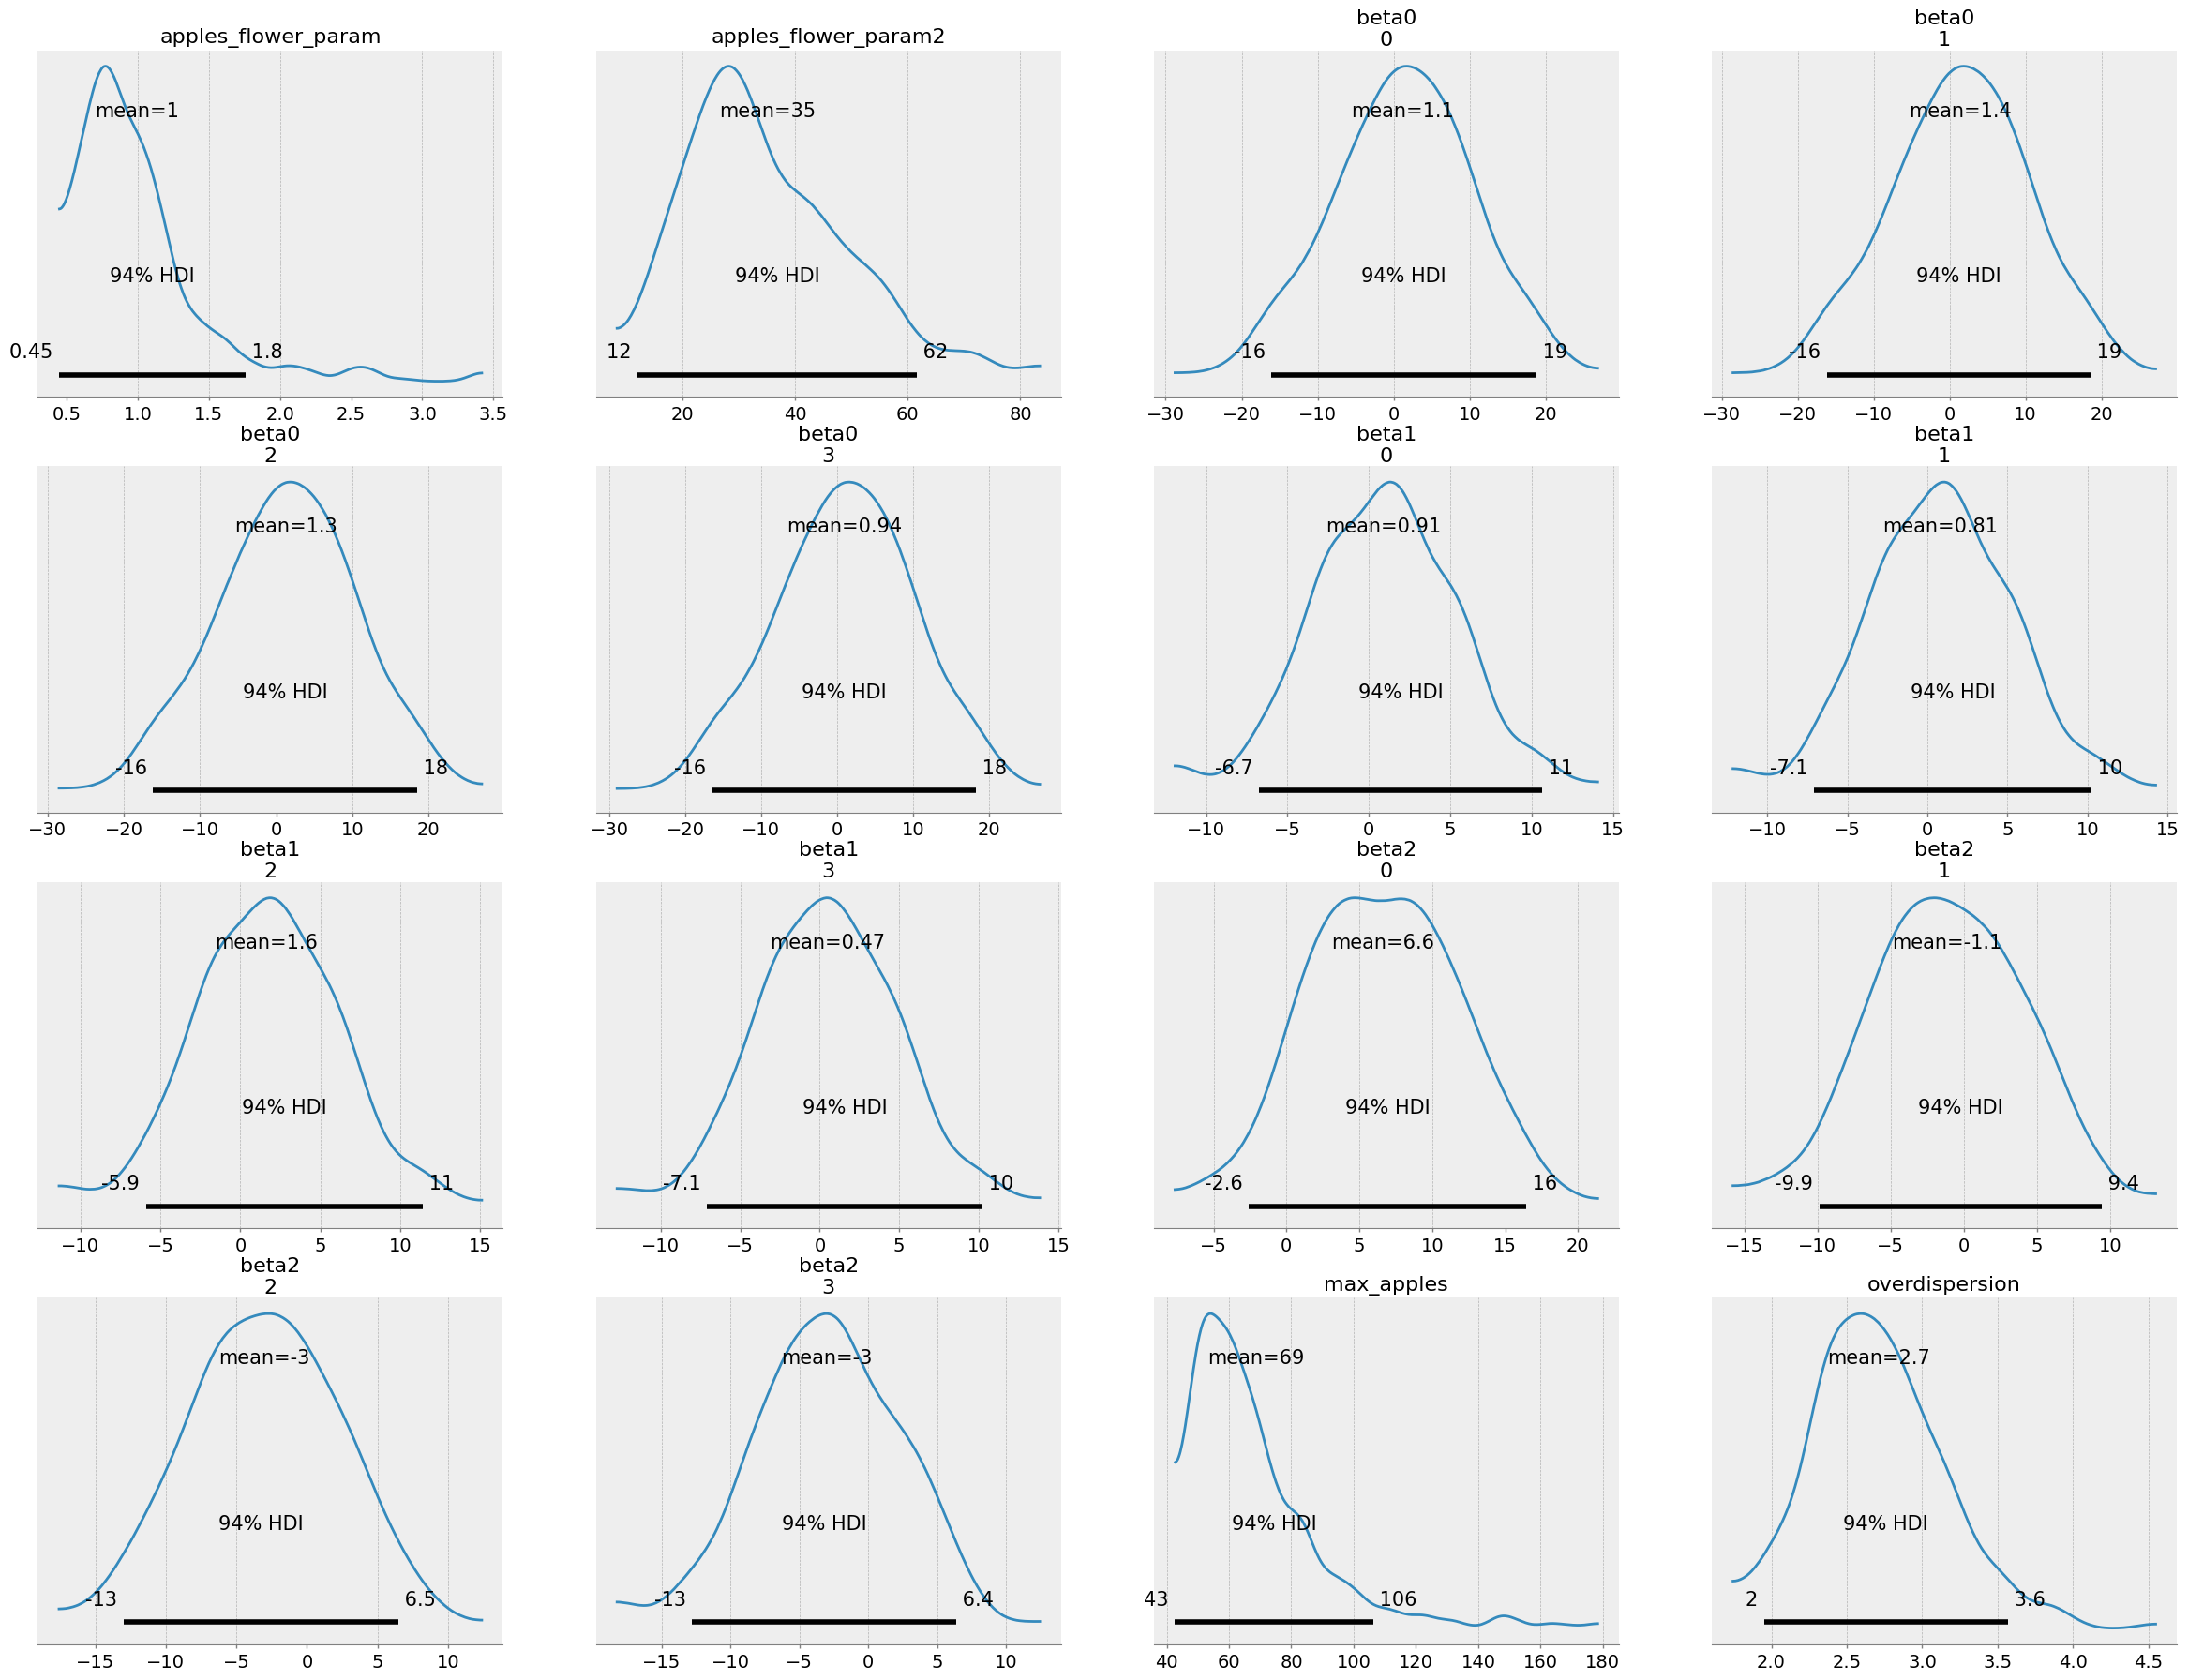

In [ ]:
posterior_samples = dict()
for key in ["apples_flower_param", "apples_flower_param2", "max_apples", "beta0", "beta1", "beta2", "overdispersion"]:
    posterior_samples[key] = torch.tensor(np.load("mc_results_params_{}_hierarchical5.npy".format(key)))

samples = dict()
samples["apple_bins"] = torch.tensor(np.load("mc_results_apple_bins_hierarchical5.npy"))
predictive = pyro.infer.Predictive(model, posterior_samples=posterior_samples)

posterior_samples_arviz = {key: value.unsqueeze(0) for key, value in posterior_samples.items()}
idata = az.from_dict(posterior=posterior_samples_arviz)
az.plot_posterior(idata)
pass

Alternatively fit the model using SVI:

In [ ]:
"""
model = AppleDistributionModelFitting()

# Define the AutoNormal guide
guide = pyro.infer.autoguide.AutoNormal(model)

# Set up the SVI optimizer and loss function (ELBO)
adam = pyro.optim.Adam({"lr": 0.01})
svi = pyro.infer.SVI(model=model, guide=guide, optim=adam, loss=pyro.infer.Trace_ELBO())

# Number of optimization steps
num_steps = 2000

# Perform SVI optimization
for step in range(num_steps):
    loss = svi.step(X, y)
    if step % 100 == 0:
        print(f"Step {step}: Loss = {loss}")
"""
pass

Visualize the posterior mean number of apples as a function of number of flower clusters.

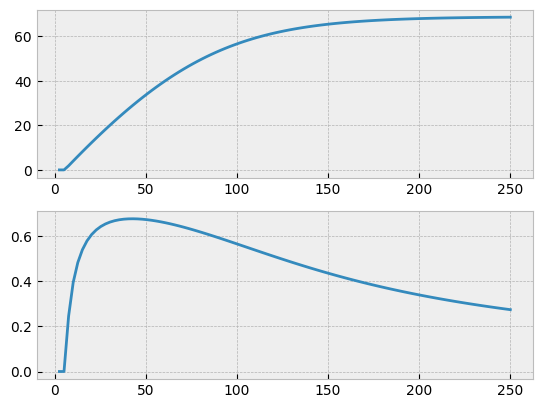

In [ ]:
thinning_targets = torch.linspace(0, 250, 100)
fig, axs = plt.subplots(2)
res = model.flowers_to_apples(
    thinning_targets,
    posterior_samples["max_apples"].mean(axis=0),
    posterior_samples["apples_flower_param"].mean(axis=0),
    posterior_samples["apples_flower_param2"].mean(axis=0),
)
axs[0].plot(thinning_targets, res*thinning_targets)
axs[1].plot(thinning_targets, res)

In [ ]:
apples_flower_param = dist.Normal(posterior_samples["apples_flower_param"].mean(), posterior_samples["apples_flower_param"].std())
max_apples = dist.Normal(posterior_samples["max_apples"].mean(), posterior_samples["max_apples"].std())
beta0 = dist.Normal(posterior_samples["beta0"].mean(axis=0), posterior_samples["beta0"].std(axis=0))
beta1 = dist.Normal(posterior_samples["beta1"].mean(axis=0), posterior_samples["beta1"].std(axis=0))
beta2 = dist.Normal(posterior_samples["beta2"].mean(axis=0), posterior_samples["beta2"].std(axis=0))

In [ ]:
beta_df = pd.DataFrame()
for i in range(3):
    beta_df[f"beta0_{i}"] = posterior_samples["beta0"][:, i]
    beta_df[f"beta1_{i}"] = posterior_samples["beta1"][:, i]
    beta_df[f"beta2_{i}"] = posterior_samples["beta2"][:, i]

Get the effective precision of the mechanical thinning device using another round of MCMC fitting.

In [ ]:
model_mech = AppleDistributionModelFitting(
    apples_flower_param=posterior_samples["apples_flower_param"],
    apples_flower_param2=posterior_samples["apples_flower_param2"],
    max_apples=posterior_samples["max_apples"],
    beta0=posterior_samples["beta0"],
    beta1=posterior_samples["beta1"],
    beta2=posterior_samples["beta2"],
    overdispersion=posterior_samples["overdispersion"],
    thinned=False,
)

In [ ]:
nuts_kernel_mech = pyro.infer.NUTS(model_mech, jit_compile=True)

mcmc_mech = pyro.infer.MCMC(nuts_kernel_mech, num_samples=50, warmup_steps=50)
mcmc_mech.run(X_mech, y_mech)
pass

Warmup:   0%|          | 0/100 [00:00, ?it/s]<ipython-input-264-b135d117f45f>:73: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
  n_trees = len(X)
<ipython-input-264-b135d117f45f>:110: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  p_total = torch.clamp(p_total, torch.tensor(0.0001), torch.tensor(0.999))
/usr/local/lib/python3.11/dist-packages/pyro/poutine/subsample_messenger.py:70: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables

Save the results to file.

In [ ]:
posterior_samples_mech = mcmc_mech.get_samples()
predictive_mech = pyro.infer.Predictive(model_mech, posterior_samples=posterior_samples_mech)
samples_mech = predictive_mech(X_mech)

for key, value in posterior_samples_mech.items():
    np.save("mc_results_params_{}_hierarchical_mech5.npy".format(key), posterior_samples_mech[key].numpy())

In [ ]:
mech_std = torch.max(X_mech * posterior_samples_mech["fuzzy_thinning_rate"], y_mech.sum(axis=1)).float().std(axis=1)
mech_std_q25 = mech_std.quantile(0.25)
mech_std_mean = mech_std.mean()
mech_std_q75 = mech_std.quantile(0.75)

mech_std_q25, mech_std_mean, mech_std_q75

(tensor(25.2871), tensor(25.8567), tensor(25.7741))

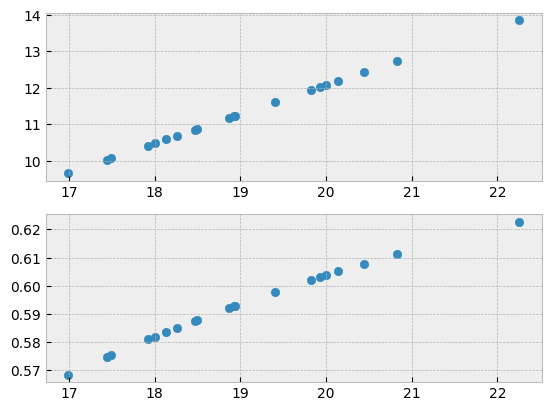

In [ ]:
#thinning_targets = torch.linspace(0, 250, 100)
fig, axs = plt.subplots(2)
res = model_mech.flowers_to_apples(
    posterior_samples_mech["fuzzy_thinning_target"].mean(axis=0),
    posterior_samples["max_apples"].mean(axis=0),
    posterior_samples["apples_flower_param"].mean(axis=0),
    posterior_samples["apples_flower_param2"].mean(axis=0),
)
axs[0].scatter(posterior_samples_mech["fuzzy_thinning_target"].mean(axis=0), res*posterior_samples_mech["fuzzy_thinning_target"].mean(axis=0))
axs[1].scatter(posterior_samples_mech["fuzzy_thinning_target"].mean(axis=0), res)

Plot posterior distributions for thinning rate and thinning target standard deviation for mechanical thinning.

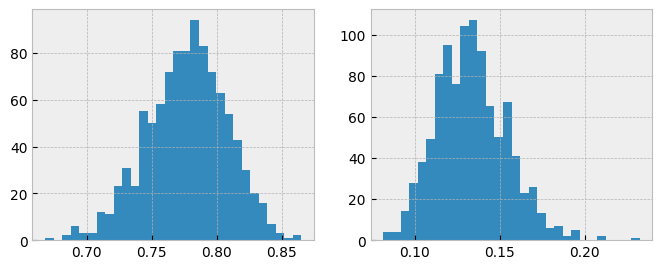

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].hist(samples_mech["thinning_rate"].flatten(), bins=30)
axs[1].hist(samples_mech["thinning_target_std"].flatten(), bins=30)

pass

Simulated and observed apple numbers.

Text(0, 0.5, 'apples')

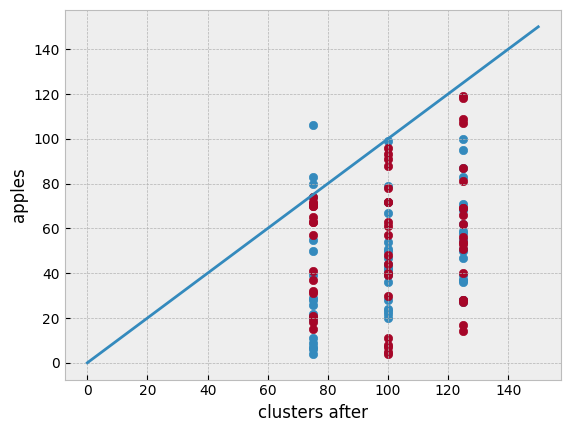

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X, y.sum(axis=1))
ax.scatter(X, apple_bins.sum(axis=[2])[np.random.randint(500)])#.sum(axis=[1])[:, 0])
ax.plot([0, 150], [0, 150])
ax.set_xlabel("clusters after")
ax.set_ylabel("apples")

#plt.scatter(fitting_y.sum(axis=1), model(fitting_X))

## Nested Monte Carlo to calculate posterior distribution of VoP

In [ ]:
n_mcmc_samples = 500
n_batches = 100
n_samples_per_paramset_batch = 100

n_samples_per_paramset = n_batches * n_samples_per_paramset_batch

offset = 20
x_test_x =  torch.arange(offset, 250, 2)
x_test = x_test_x.unsqueeze(1).expand([-1, n_samples_per_paramset_batch]).flatten()

In [ ]:
preds = torch.zeros((n_mcmc_samples, len(x_test_x), n_samples_per_paramset, 4))

In [ ]:
import gc

In [ ]:
for batch_i in trange(n_batches):
    gc.collect()
    preds_batch = get_apple_bins(predictive(x_test))
    preds_batch = preds_batch.reshape(n_mcmc_samples, len(x_test_x), n_samples_per_paramset_batch, 4)
    preds[:, :, batch_i*n_samples_per_paramset_batch:(batch_i+1)*n_samples_per_paramset_batch, :] = preds_batch

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
gc.collect()

17

In [ ]:
preds_kg = preds * kg_per_apple_category

In [ ]:
true_targets = [75, 100, 125]

mask = dict()
mask[75] = torch.tensor((tdf[tdf.target!="mech"].target == "75").to_numpy())
mask[100] = torch.tensor((tdf[tdf.target!="mech"].target == "100").to_numpy())
mask[125] = torch.tensor((tdf[tdf.target!="mech"].target == "125").to_numpy())

true_masses = [y_mass[mask[tt]].sum(axis=1).mean() for tt in true_targets]
true_numbers = [y[mask[tt]].sum(axis=1).type(torch.float).mean() for tt in true_targets]

true_numbers_by_class = np.array([y[mask[tt]].type(torch.float).mean(axis=0).numpy() for tt in true_targets])

true_revenues = [get_revenue_torch(y_mass[mask[tt]]).mean() for tt in true_targets]

In [ ]:
rng = np.random.default_rng(1)
n_random_draws = 10
random_draws = rng.integers(n_mcmc_samples, size=n_random_draws)

coloration_class_idxs = torch.arange(2)
size_class_idxs = torch.arange(10)

revenue = get_revenue_torch(preds_kg)
revenue_mean = revenue.mean(axis=2).mean(axis=0)
revenue_std = revenue.mean(axis=2).std(axis=0)
revenue_q25 = revenue.mean(axis=2).quantile(0.25, axis=0)
revenue_q75 = revenue.mean(axis=2).quantile(0.75, axis=0)

kg = preds_kg.mean(axis=[0, 2]).sum(axis=1)
n_apples = preds.mean(axis=[0, 2]).sum(axis=1)
n_apples_std = preds.sum(axis=3).mean(axis=2).std(axis=0)
n_apples_q25 = preds.sum(axis=3).mean(axis=2).quantile(0.25, axis=0)
n_apples_q75 = preds.sum(axis=3).mean(axis=2).quantile(0.75, axis=0)

In [ ]:
preds_mean = preds.mean(axis=[0, 2])
preds_random = preds[random_draws].mean(axis=[2])

In [ ]:
del preds, preds_kg
gc.collect()

17

Comprehensive figure for explorative analysis

Text(0.5, 1.0, 'n apples')

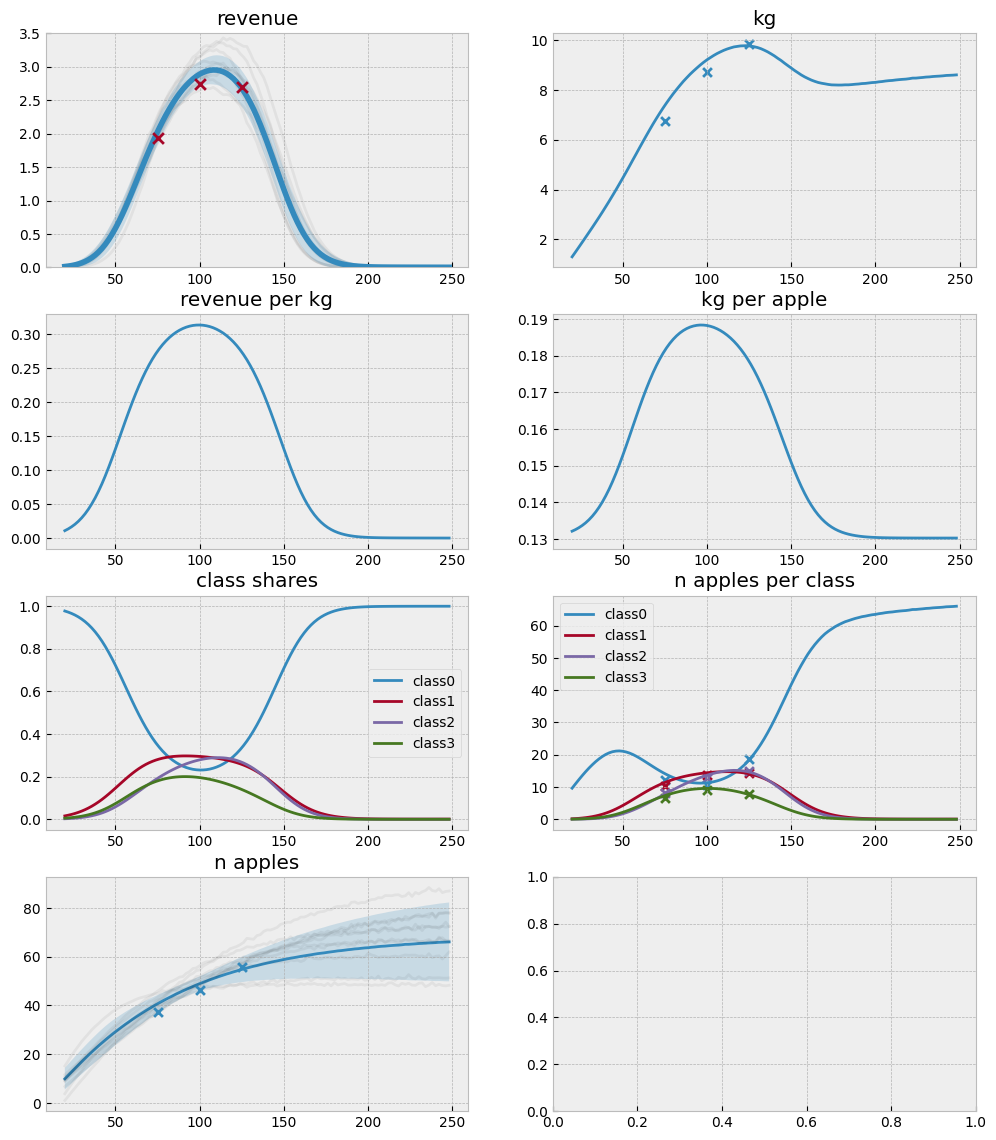

In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(12, 14), sharex=False)
axs = axs.flatten()
axs[0].plot(x_test_x, revenue_mean, zorder=3, linewidth=4)
axs[0].fill_between(x_test_x, revenue_mean - revenue_std, revenue_mean + revenue_std, alpha=0.2, zorder=2.5)
for i in range(n_random_draws):
    axs[0].plot(x_test_x, revenue[random_draws[i]].mean(axis=1), color="k", alpha=0.05, zorder=2)
axs[0].scatter(true_targets, true_revenues, s=60, marker="x", color="C1", zorder=4)
axs[0].set_title("revenue")
axs[0].set_ylim(0, 3.5)
axs[1].plot(x_test_x, kg)
axs[1].scatter(true_targets, true_masses, s=40, marker="x", color="C0")
axs[1].set_title("kg")
axs[2].plot(x_test_x, revenue_mean / kg)
axs[2].set_title("revenue per kg")
axs[3].plot(x_test_x, kg / n_apples)
axs[3].set_title("kg per apple")
axs[4].plot(x_test_x, preds_mean[:,0] / n_apples, label="class0")
axs[4].plot(x_test_x, preds_mean[:,1] / n_apples, label="class1")
axs[4].plot(x_test_x, preds_mean[:,2] / n_apples, label="class2")
axs[4].plot(x_test_x, preds_mean[:,3] / n_apples, label="class3")
axs[4].legend()
axs[4].set_title("class shares")

axs[5].plot(x_test_x, preds_mean[:,0], label="class0")
axs[5].plot(x_test_x, preds_mean[:,1], label="class1")
axs[5].plot(x_test_x, preds_mean[:,2], label="class2")
axs[5].plot(x_test_x, preds_mean[:,3], label="class3")

for i in range(4):
    axs[5].scatter(true_targets, true_numbers_by_class[:, i], s=40, marker="x", c=f"C{i}")

axs[5].legend()
axs[5].set_title("n apples per class")

axs[6].plot(x_test_x, n_apples)
axs[6].fill_between(x_test_x, n_apples - n_apples_std, n_apples + n_apples_std, alpha=0.2)
for i in range(n_random_draws):
    axs[6].plot(x_test_x, preds_random[i].sum(axis=1), color="k", alpha=0.05, zorder=2)
axs[6].scatter(true_targets, true_numbers, s=40, marker="x", color="C0", zorder=4)

axs[6].set_title("n apples")



Final figure for paper

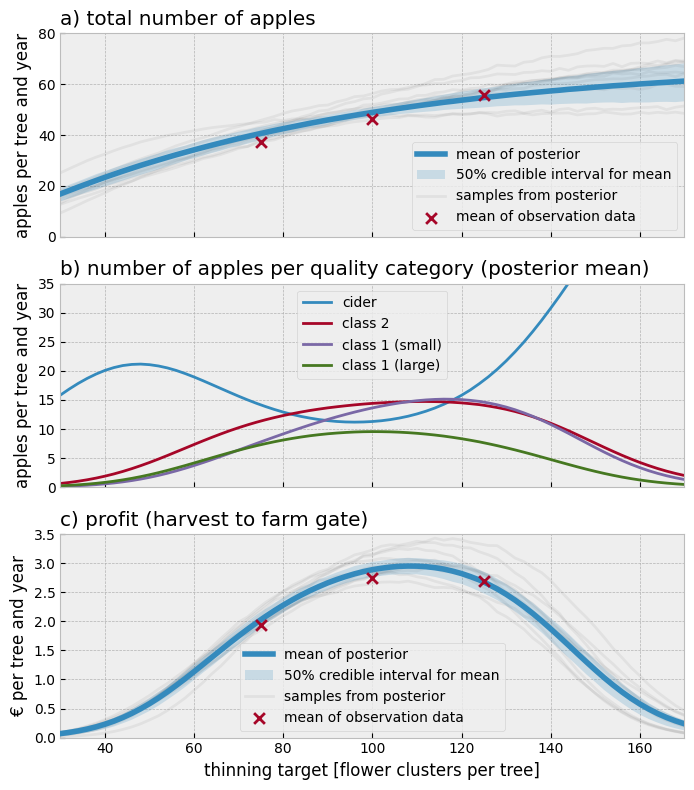

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(7, 8), sharex=True)
axs = axs.flatten()

axs[0].plot(x_test_x, n_apples, zorder=3, linewidth=4, label="mean of posterior")
axs[0].fill_between(x_test_x, n_apples_q25, n_apples_q75, alpha=0.2, zorder=2.5, label="50% credible interval for mean")
for i in range(n_random_draws):
    axs[0].plot(x_test_x, preds_random[i].sum(axis=1), color="k", alpha=0.05, zorder=2, label="samples from posterior" if not i else "")
axs[0].scatter(true_targets, true_numbers, s=60, marker="x", color="C1", zorder=4, label="mean of observation data")

axs[0].set_title("a) total number of apples", loc='left')
axs[0].set_ylabel("apples per tree and year")


axs[0].set_ylim(0, 80)
axs[0].legend()


for i in range(4):
    axs[1].plot(x_test_x, preds_mean[:,i], label=category_labels[i])

#for i in range(4):
#    axs[2].scatter(true_targets, true_numbers_by_class[:, i], s=40, marker="x", c=f"C{i}")

axs[1].legend()
#axs[4].plot(x_test, preds_raw.mean(axis=[0, 2])[:, 1]/200)
axs[1].set_title("b) number of apples per quality category (posterior mean)", loc='left')
axs[1].set_ylabel("apples per tree and year")

axs[1].set_ylim(0, 35)
axs[1].legend()

axs[1].set_xlim(30, 170)


axs[2].plot(x_test_x, revenue_mean, zorder=3, linewidth=4, label="mean of posterior")
axs[2].fill_between(x_test_x, revenue_q25, revenue_q75, alpha=0.2, zorder=2.5, label="50% credible interval for mean")
for i in range(n_random_draws):
    axs[2].plot(x_test_x, revenue[random_draws[i]].mean(axis=1), color="k", alpha=0.05, zorder=2, label="samples from posterior" if not i else "")
axs[2].scatter(true_targets, true_revenues, s=60, marker="x", color="C1", zorder=4, label="mean of observation data")
axs[2].set_ylabel("€ per tree and year")
axs[2].set_title("c) profit (harvest to farm gate)", loc='left')
axs[2].set_ylim(0, 3.5)
axs[2].legend()

axs[2].set_xlabel("thinning target [flower clusters per tree]")


fig.tight_layout()

fig.savefig("absolute_posterior1.png", dpi=600)
fig.savefig("absolute_posterior1.svg")

## Simulate mechanical thinning

In [ ]:
model_mech_syn = AppleDistributionModelFitting(
    apples_flower_param=posterior_samples["apples_flower_param"],
    max_apples=posterior_samples["max_apples"],
    beta=[posterior_samples["beta0"], posterior_samples["beta1"], posterior_samples["beta2"]],
    overdispersion=posterior_samples["overdispersion"],
    thinned=False,
)
pred_mech_syn = pyro.infer.Predictive(model_mech_syn, num_samples=10000)

thinning_rates = torch.linspace(0.7, 1, 50)
rate_revenues = torch.zeros(len(thinning_rates))

for i, rate in enumerate(tqdm.tqdm(thinning_rates)):
    pred_mech_syn_res = pred_mech_syn(X_mech, thinning_rate=rate, thinning_target_std=samples_mech["thinning_target_std"].mean())
    rate_revenues[i] = get_revenue_torch(pred_mech_syn_res["apple_bins"] * kg_per_apple_category).mean()

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
np.save("rate_revenues_large_thinning_std.npy", rate_revenues.numpy())

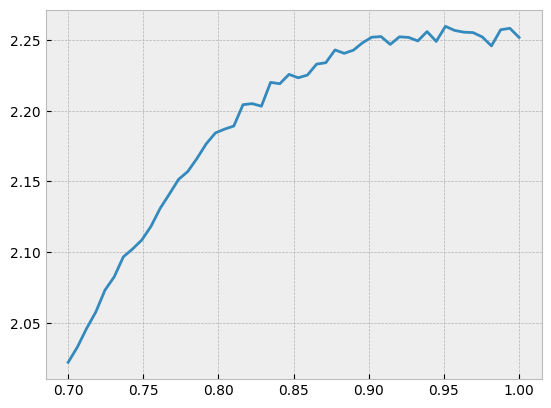

In [ ]:
plt.plot(thinning_rates, rate_revenues)

In [ ]:
model_mech_syn = AppleDistributionModelFitting(
    apples_flower_param=posterior_samples["apples_flower_param"],
    max_apples=posterior_samples["max_apples"],
    beta=[posterior_samples["beta0"], posterior_samples["beta1"], posterior_samples["beta2"]],
    thinned=False,
)
pred_mech_syn = pyro.infer.Predictive(model_mech_syn, num_samples=10000)

thinning_stds = torch.linspace(0.001, 0.5, 50)
std_revenues = torch.zeros(len(thinning_stds))
std_q25 = torch.zeros(len(thinning_stds))
std_q75 = torch.zeros(len(thinning_stds))

batches = 5

std_revenue_total = torch.empty((10 * batches, 50, 20))

for batch_i in trange(batches):
    for i, thinning_std in enumerate(tqdm.tqdm(thinning_stds)):
        pred_mech_syn_res = pred_mech_syn(X_mech, thinning_rate=0.87, thinning_target_std=thinning_std)
        pred_mech_syn_res = pred_mech_syn_res["apple_bins"].reshape(10, 1000, 20, 4).mean(axis=1)
        std_revenue = get_revenue_torch(pred_mech_syn_res * kg_per_apple_category)
        std_revenue_total[batch_i*10:(batch_i+1)*10, i, :] = std_revenue
        #std_revenues[i] = std_revenue.mean()
        #std_q25[i] = std_revenue.quantile(0.25, axis=0).mean()
        #std_q75[i] = std_revenue.quantile(0.75, axis=0).mean()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
np.save("std_revenue_total_large.npy", std_revenue_total.numpy())

In [ ]:
std_revenues = std_revenue_total.mean(axis=0).mean(axis=1)
std_q25 = std_revenue_total.quantile(0.25, axis=0).mean(axis=1)
std_q75 = std_revenue_total.quantile(0.75, axis=0).mean(axis=1)

In [ ]:
samples_mech["thinning_target_std"].squeeze().mean()

tensor(0.1333)

##VOP Calculation

In [ ]:
x_test_x[revenue.mean(axis=2).argmax(axis=1)].float().mean()

tensor(108.3080)

In [ ]:
best_thinning_target_idx = revenue_mean.argmax()
best_thinning_target = x_test_x[best_thinning_target_idx]
best_thinning_target

tensor(108)

In [ ]:
revenue_perfect_precision = revenue[:, best_thinning_target_idx] #.mean(axis=1)

In [ ]:
n_batches = 10

gc.collect()

vop_mean = []
vop_std = []
vop_q25 = [] # 0.1587
vop_q75 = [] # 0.8413
stds = np.arange(0, 40)


value_of_precision_total = torch.empty((len(stds), n_mcmc_samples*n_batches))

for batch_i in trange(n_batches):
    value_of_precisions = torch.empty((len(stds), n_mcmc_samples))

    for i in tqdm.tqdm((stds)):
        imperfect_thinning_target_idxs = np.round(np.random.normal(loc=best_thinning_target_idx, scale=i, size=n_mcmc_samples)).astype(int)
        imperfect_thinning_target_idxs = np.clip(imperfect_thinning_target_idxs, 0, len(x_test_x)-1)
        revenue_imperfect_precision = revenue[:, imperfect_thinning_target_idxs].mean(axis=1)
        value_of_precision = (revenue_perfect_precision - revenue_imperfect_precision).mean(axis=1)
        value_of_precisions[i] = value_of_precision

        #vop_mean.append(value_of_precision.mean())
        #vop_std.append(value_of_precision.std())
        #vop_q25.append(np.quantile(value_of_precision, 0.25))
        #vop_q75.append(np.quantile(value_of_precision, 0.75))
    gc.collect()

    value_of_precision_total[:, batch_i*n_mcmc_samples:(batch_i+1)*n_mcmc_samples] = value_of_precisions


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
np.save("aboslute_value_of_precision_total_large_hier5.npy", value_of_precision_total.numpy())

Final figure for paper

In [ ]:
vop_mean = value_of_precision_total.mean(axis=1)
vop_std = value_of_precision_total.std(axis=1)
vop_q25 = value_of_precision_total.quantile(0.25, axis=1)
vop_q75 = value_of_precision_total.quantile(0.75, axis=1)

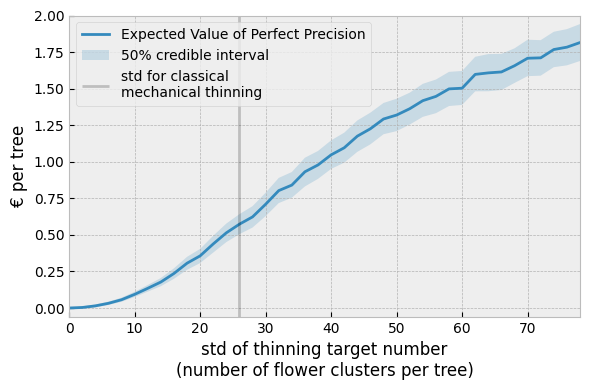

In [ ]:
fig, ax = plt.subplots(1, figsize=(6, 4), sharey=True)
ax.plot(stds*2, vop_mean, label="Expected Value of Perfect Precision")
ax.fill_between(stds*2, np.array(vop_q25), np.array(vop_q75), alpha=0.2, label="50% credible interval")
ax.vlines(mech_std_mean, -1, 3, color="k", label="std for classical \nmechanical thinning", alpha=0.2)

ax.set_xlabel("std of thinning target number\n(number of flower clusters per tree)")
ax.set_ylabel("€ per tree")
ax.legend(loc="upper left")
ax.set_xlim(0, 39*2)
ax.set_ylim(-0.06, 2)


fig.tight_layout()

fig.savefig("vop1.png", dpi=600)
fig.savefig("vop1.svg")

In [ ]:
vop_mean[list(stds*2).index(mech_std_mean.round().int())]

tensor(0.5733)

In [ ]:
vop_std[list(stds*2).index(mech_std_mean.round().int())]

tensor(0.0998)

In [ ]:
vop_diff = value_of_precision_total[list(stds*2).index(mech_std_mean.round().int())] - value_of_precision_total[list(stds*2).index(10)]

In [ ]:
vop_diff.mean(), vop_diff.std()

(tensor(0.4799), tensor(0.0812))